In [1]:
# import statements
import numpy as np
import xarray as xr
import glob
import random
import cartopy.io.shapereader as shpreader
import shapely.geometry as sgeom
from shapely.ops import unary_union
from shapely.prepared import prep
import sys
import matplotlib.pyplot as plt
import TestingTrainingSplit_CV
from matplotlib.colors import LinearSegmentedColormap


# Get names of models in which we are testing on
path_to_data = '/home/disk/pna2/aodhan/SurfaceTrendLearning/PoChedleyEtAl2022/TASmaps/*_TrendMaps.nc'
ModelNames = [i[70:-16] for i in glob.glob(path_to_data)]

# Get observational data
observational_trends = glob.glob('/home/disk/p/aodhan/SurfaceTrendLearing/PolarTASApplication/TASObsTrends/*.npy')
observational_trend_maps = [np.load(observational_trends[i]) for i in range(0,len(observational_trends))]
latitudes = np.linspace(-88.75,88.75,72)
weights = np.cos(np.deg2rad(latitudes)) # these will be used to weight predictors
observational_trend_maps_weighted = np.multiply(observational_trend_maps, weights[np.newaxis,:,np.newaxis])
observational_trend_maps_reshaped = np.reshape(observational_trend_maps_weighted, (3, 72*144))

# Create Custom Color Map
colors = np.array([(22,98,248), (48,141,250), (71,172,251), (100,201,252), (129,222,253),(162,240,254), (215,249,253), (255,255,255), 
                   (255,255,255), (255,249,217), (247,236,155), (254,221,128), (254,202,100), (255,173,71), (252,142,42), (255,101,15)])/255
custom_cmap = LinearSegmentedColormap.from_list('cmap', colors)

# Do CV train-test-split 
TrainingPredictorData, TrainingTargetData, TestingPredictorData, TestingTargetData, TestingTotalTrend = TestingTrainingSplit_CV.training_testing_split(path_to_data)


In [9]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import OrthogonalMatchingPursuit
from scipy import stats
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_approximation import Nystroem


# iterate over all CV folds (there should be eqaul number of CV folds as models)
NameValidatationPredictions = []
gistemp_predictions = []
era5_predictions = []
hadcrut_predictions = []
for model_idx in range(len(ModelNames)):

    # find X and Y data
    X_train_all = np.array(TrainingPredictorData[model_idx])
    X_test_all = np.array(TestingPredictorData[model_idx])
    Y_train_all = np.array(TrainingTargetData[model_idx])
    Y_test_all = np.array(TestingTargetData[model_idx])

    # select whether you want whole region (0), just ocean (1), or land(2)
    Y_train_all_target = Y_train_all[:,:,0,:]
    Y_test_all_target = Y_test_all[:,:,0,:]

    # Reshape Y data for model
    Y_train_shape = np.shape(Y_train_all_target)
    Y_test_shape = np.shape(Y_test_all_target)
    Y_train_reshaped = np.reshape(Y_train_all_target, (Y_train_shape[0], Y_train_shape[1]*Y_train_shape[2]))
    Y_test_reshaped = np.reshape(Y_test_all_target, (Y_test_shape[0], Y_test_shape[1]*Y_test_shape[2]))


    kernel_feature = Nystroem(kernel='rbf', random_state=0)
    X_train_transformed = kernel_feature.fit_transform(X_train_all)
    X_test_transformed = kernel_feature.transform(X_test_all)

    # Model Design
    MLmodel = PLSRegression(n_components=9)    


    #TrainingTargetDataReshaped = TrainingTargetDataReshaped[:,0]
    pls_model = MLmodel.fit(X_train_transformed, Y_train_reshaped)

    # Predict using trained model
    Y_pred = MLmodel.predict(X_test_transformed)
    
    # Apply trained model to observations
    #Y_pred_Gistemp = MLmodel.predict(observational_trend_maps_reshaped[0].reshape(1, -1))
    #Y_pred_ERA5 = MLmodel.predict(observational_trend_maps_reshaped[1].reshape(1, -1))
    #Y_pred_HadCrut = MLmodel.predict(observational_trend_maps_reshaped[2].reshape(1, -1))
    
    # Save output for plotting
    #gistemp_predictions.append(Y_pred_Gistemp)
    #era5_predictions.append(Y_pred_ERA5)
    #hadcrut_predictions.append(Y_pred_HadCrut)
    NameValidatationPredictions.append([ModelNames[model_idx], Y_test_reshaped, Y_pred])


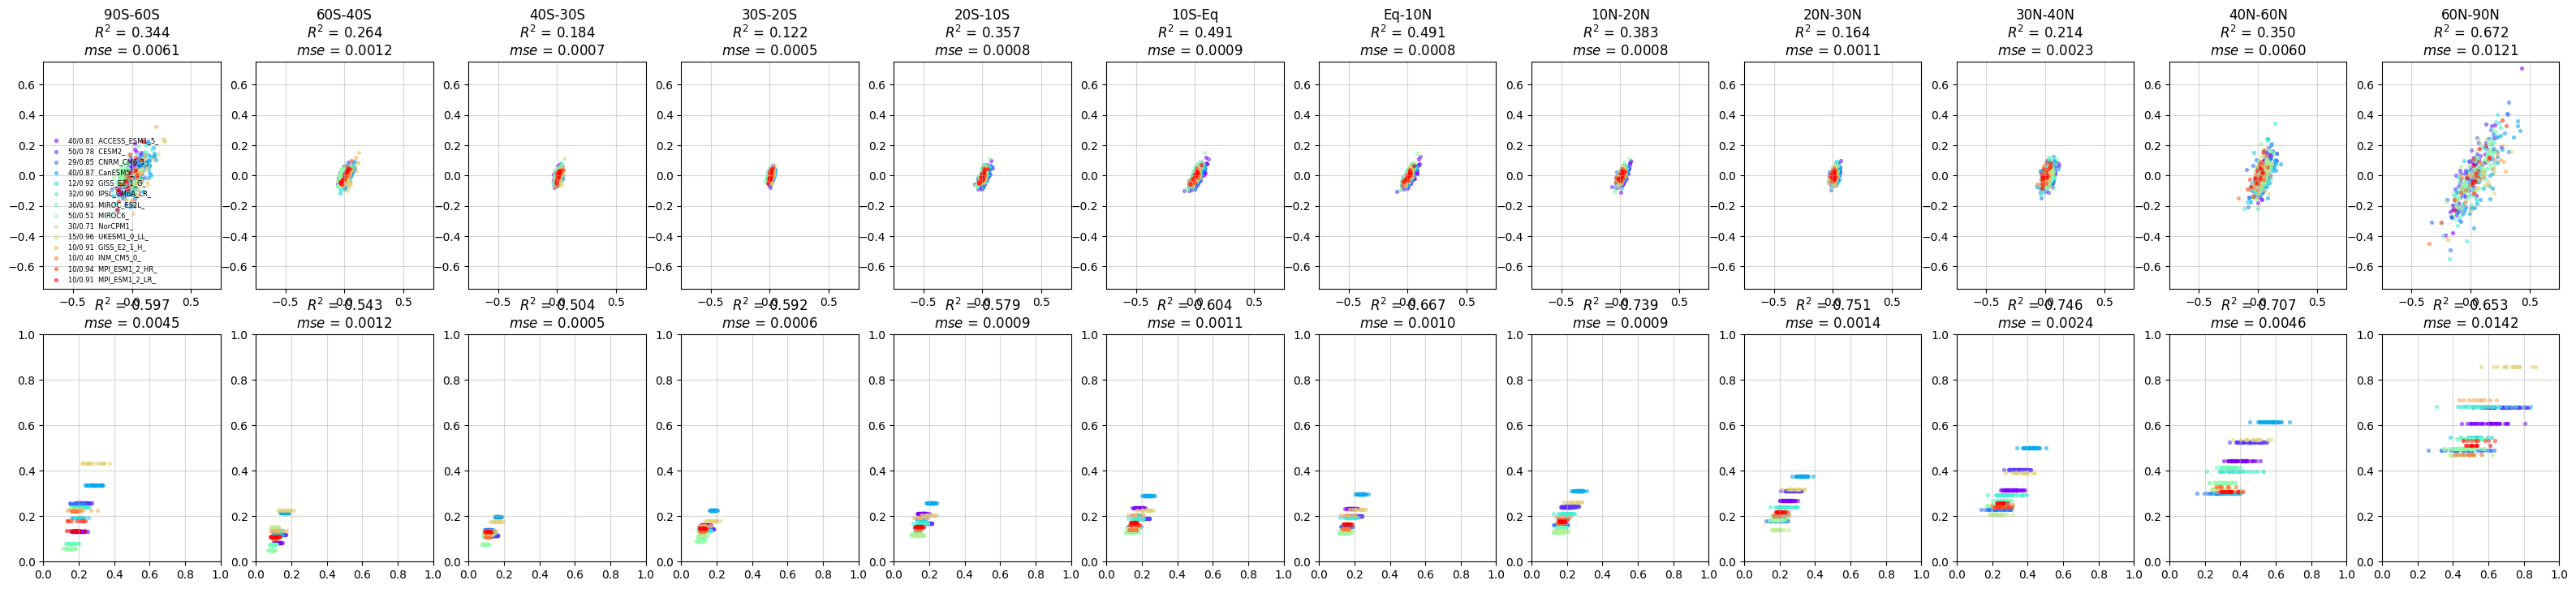

In [6]:
fig, axs = plt.subplots(2, 12, figsize=(40, 8))
import matplotlib.cm as cm

####################################################################################
colors = cm.rainbow(np.linspace(0, 1, 14))

NatValAndPred_all = []
ForValAndPred_all = []

for model_idx in range(len(NameValidatationPredictions)):
    modelName = NameValidatationPredictions[model_idx][0]    
    ValidationData = NameValidatationPredictions[model_idx][1]
    PredictedData = NameValidatationPredictions[model_idx][2]
    ValidationData_reshaped = np.reshape(ValidationData, (len(ValidationData), 2, 12))
    PredictedData_reshaped = np.reshape(PredictedData, (len(PredictedData), 2, 12))
    TotalData = TestingTotalTrend[model_idx]
    N_ensembles = len(PredictedData)
    NatValAndPred_onemodel = []
    ForValAndPred_onemodel = []
    
    r_values = []
    for col in range(2):
        NatValAndPred = []
        ForValAndPred = []
        for row in range(12):
            axs_obj = axs[col, row]
            val = ValidationData_reshaped[:,col, row]
            pred = PredictedData_reshaped[:,col,row]
            r = stats.pearsonr(val, pred)[0]
            label_id = str(N_ensembles) + '/' + str(r)[:4] + ' ' + ' ' + modelName
            
            axs_obj.scatter(pred, val, label=label_id, color=colors[model_idx], s=8, alpha=0.5)
            if row == 0:
                if col == 0:
                    axs_obj.legend(loc=0, prop={'size': 6}, frameon=False)
            #axs_obj.set_ylim(-1,1)
            #axs_obj.set_xlim(-1,1)
            #axs_obj.set_xlabel('Predicted Trend (K/decade)')
            axs_obj.grid(alpha=0.5)
            if col == 0:
                NatValAndPred.append([val, pred])
                axs_obj.set_ylim(-.75,.75)
                axs_obj.set_xlim(-.75,.75)
            if col == 1:
                ForValAndPred.append([val, pred])
                axs_obj.set_ylim(0,1)
                axs_obj.set_xlim(0,1)
        NatValAndPred_onemodel.append(NatValAndPred)
        ForValAndPred_onemodel.append(ForValAndPred)
    NatValAndPred_all.append(NatValAndPred_onemodel)
    ForValAndPred_all.append(ForValAndPred_onemodel)

latitudes = ['90S-60S', '60S-40S','40S-30S', '30S-20S', '20S-10S', '10S-Eq', 'Eq-10N', '10N-20N','20N-30N','30N-40N', '40N-60N', '60N-90N']

for i in range(2):
    for j in range(12):
        plot = axs[i,j] 
        all_data = []
        for m in range(14):
            d = plot.collections[m]
            d.set_offset_position('data')
            data_from_plot = d.get_offsets()
            all_data.append(data_from_plot)
        flat_array = np.array([item for sublist in all_data for item in sublist])
        total_r = stats.pearsonr(flat_array[:,0], flat_array[:,1])[0]
        total_mse = np.nanmean(np.square(flat_array[:,0] - flat_array[:,1]))
        plot.set_title('$R^{2}$ = ' +  str(np.square(total_r))[:5] + '\n$mse$ = ' + str(total_mse)[:6])
        if i ==0:
            plot.set_title(latitudes[j]+'\n$R^{2}$ = ' +  str(np.square(total_r))[:5] + '\n$mse$ = ' + str(total_mse)[:6])

